# Stability Based Robustness Evaluation

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from model_info import model_to_params, model_to_traindata, model_to_year, model_to_abrv
from copy import deepcopy
import tqdm

In [15]:
hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']

In [116]:
en_models = [
    'wav2vec2-large-960h-lv60-self',
    'hubert-large-ls960-ft',
    'wav2vec2-large-robust-ft-libri-960h',
    'wav2vec2-base-960h',
    'whisper-large-v2',
    'whisper-tiny.en',
    'deepspeech',
]

## Data Loading and Annotation

First we will read the CSV using Pandas and add to it some meta data related to the models

In [46]:
df = pd.read_csv('results/collated_PertRob_results.csv')
df['model'] = df['model'].str.replace('rnnt', 'emformer-rnnt')
df['# Model Params'] = [model_to_params[model] for model in df['model']]
df['Training Data (hrs)'] = [model_to_traindata[model] for model in df['model']]
df['year'] = [model_to_year[model] for model in df['model']]
df['language'] = ['en' if df['dataset'][i] == 'librispeech_asr' else 'es' for i in range(len(df))]
df['model (abrv)'] = [model_to_abrv[m] for m in df['model']]
df = df[(df['model'] != 'emformer-rnnt') & (df['model'] != 'wav2vec2-large-960h') & df['model'].isin(model_to_params.keys())]
df = df.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1)
df = df.sort_values(by=['model', 'augmentation', 'severity', 'id', 'pert_idx'])
df = df.reset_index(drop=True)

In [17]:
df['model'].unique()

array(['deepspeech', 'hubert-large-ls960-ft', 'hubert-xlarge-ls960-ft',
       'mms-1b-fl102', 'wav2vec2-base-10k-voxpopuli-ft-es',
       'wav2vec2-base-960h', 'wav2vec2-large-960h-lv60-self',
       'wav2vec2-large-robust-ft-libri-960h',
       'wav2vec2-large-xlsr-53-spanish', 'whisper-large-v2',
       'whisper-small', 'whisper-tiny', 'whisper-tiny.en'], dtype=object)

# Metric Computation

### WER/CER Degradation (WERD/CERD)
Computing WER/CER degradation (WERD) i.e. the difference between the WER/CER on the perturbed and unperturbed test sets.

$WERD^M_\text{pert,sev}=WER^M_\text{pert,sev} - WER^M_{\text{clean}}$

In [48]:
base_model = 'deepspeech'
werd_vals = np.zeros(len(df))
cerd_vals = np.zeros(len(df))
for model in df['model'].unique():
    for aug in df['augmentation'].unique():
        for severity in df['severity'].unique():
            print(model, aug, severity)
            sub_df = df[(df['model'] == model)]
            sub_df = sub_df[(sub_df['augmentation'] == aug)]
            sub_df = sub_df[(sub_df['severity'] == severity)]
            sub_df = sub_df.sort_values(by=['pert_idx', 'id'])
            
            if aug in ['gnoise', 'uniose', 'env_noise']:
                clean_rows = sub_df[sub_df['pert_idx'] == 0]
                for pidx in sub_df['pert_idx'].unique():
                    if pidx == 0:
                        continue
                    pert_rows = sub_df[sub_df['pert_idx'] == pidx]
                    werds = (pert_rows['wer'].values - clean_rows['wer'].values)
                    cerds = (pert_rows['cer'].values - clean_rows['cer'].values)
                    werd_vals[pert_rows.index] = werds
                    cerd_vals[pert_rows.index] = cerds
df['werd'] = werd_vals
df['cerd'] = cerd_vals
df
                        
                

deepspeech env_noise 1
deepspeech env_noise 2
deepspeech env_noise_esc50 1
deepspeech env_noise_esc50 2
deepspeech gnoise 1
deepspeech gnoise 2
deepspeech slowdown 1
deepspeech slowdown 2
deepspeech speedup 1
deepspeech speedup 2
hubert-large-ls960-ft env_noise 1
hubert-large-ls960-ft env_noise 2
hubert-large-ls960-ft env_noise_esc50 1
hubert-large-ls960-ft env_noise_esc50 2
hubert-large-ls960-ft gnoise 1
hubert-large-ls960-ft gnoise 2
hubert-large-ls960-ft slowdown 1
hubert-large-ls960-ft slowdown 2
hubert-large-ls960-ft speedup 1
hubert-large-ls960-ft speedup 2
hubert-xlarge-ls960-ft env_noise 1
hubert-xlarge-ls960-ft env_noise 2
hubert-xlarge-ls960-ft env_noise_esc50 1
hubert-xlarge-ls960-ft env_noise_esc50 2
hubert-xlarge-ls960-ft gnoise 1
hubert-xlarge-ls960-ft gnoise 2
hubert-xlarge-ls960-ft slowdown 1
hubert-xlarge-ls960-ft slowdown 2
hubert-xlarge-ls960-ft speedup 1
hubert-xlarge-ls960-ft speedup 2
mms-1b-fl102 env_noise 1
mms-1b-fl102 env_noise 2
mms-1b-fl102 env_noise_esc50 1

,id,reference,prediction,wer,cer,pert_idx,model,augmentation,severity,dataset,# Model Params,Training Data (hrs),year,language,model (abrv),werd,cerd
0,1089-134686-0000,he hoped there would be stew for dinner turnip...,he hoped there would be stow for dinner turnip...,0.392857,0.088608,0,deepspeech,env_noise,1,librispeech_asr,86000000.0,960,2016,en,ds,0.000000,0.000000
1,1089-134686-0000,he hoped there would be stew for dinner turnip...,he hoped therewohbe scoon presinner turnit and...,0.678571,0.259494,1,deepspeech,env_noise,1,librispeech_asr,86000000.0,960,2016,en,ds,0.285714,0.170886
2,1089-134686-0000,he hoped there would be stew for dinner turnip...,be hoped thewohe coon presinner turnit and per...,0.714286,0.278481,2,deepspeech,env_noise,1,librispeech_asr,86000000.0,960,2016,en,ds,0.321429,0.189873
3,1089-134686-0000,he hoped there would be stew for dinner turnip...,he hoped theeworbe coon presinner turnitan per...,0.714286,0.284810,3,deepspeech,env_noise,1,librispeech_asr,86000000.0,960,2016,en,ds,0.321429,0.196203
4,1089-134686-0000,he hoped there would be stew for dinner turnip...,he hoped therwobe scoon presinner turnit and p...,0.642857,0.265823,4,deepspeech,env_noise,1,librispeech_asr,86000000.0,960,2016,en,ds,0.250000,0.177215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701995,908-31957-0023,i love thee freely as men strive for right i l...,i love beef really as men strive for right i ...,0.166667,0.104651,25,whisper-tiny.en,speedup,1,librispeech_asr,39000000.0,563000,2023,en,wsp-tn.en,0.000000,0.000000
701996,908-31957-0023,i love thee freely as men strive for right i l...,i love beef really as men strive for right i ...,0.166667,0.104651,26,whisper-tiny.en,speedup,1,librispeech_asr,39000000.0,563000,2023,en,wsp-tn.en,0.000000,0.000000
701997,908-31957-0023,i love thee freely as men strive for right i l...,i love beef really as men strive for right i ...,0.166667,0.104651,27,whisper-tiny.en,speedup,1,librispeech_asr,39000000.0,563000,2023,en,wsp-tn.en,0.000000,0.000000
701998,908-31957-0023,i love thee freely as men strive for right i l...,i love beef really as men strive for right i ...,0.166667,0.104651,28,whisper-tiny.en,speedup,1,librispeech_asr,39000000.0,563000,2023,en,wsp-tn.en,0.000000,0.000000


In [51]:
df['num_ref_words'] = [len(x.split()) for x in df['reference'].values]
df['num_word_errors'] = df['wer'].values * df['num_ref_words'].values

### WER Variance (WERV)

We randomly sample $K$ perturbations of a given type and severity, and perturb the clean dataset, $\mathcal{X}$, with them to obtain $\mathcal{X^{(1)}},...,\mathcal{X^{(1)}}$. We then compute WERV as follows:

$WERV = Var_k\left(WER^M_\text{pert,sev}(\mathcal{X}^{(k)})\right)$

#### Perturbation-wise WERV of English Models

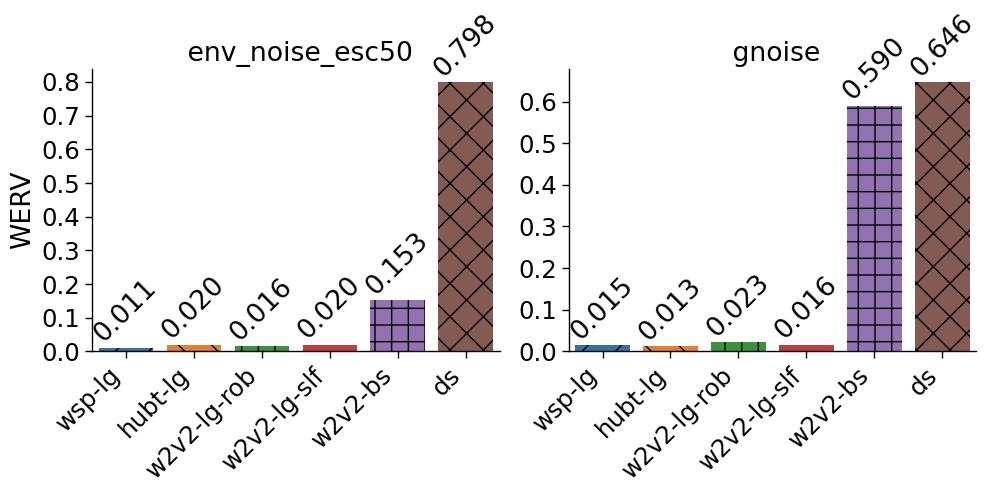

In [185]:
# filter results to include only results from English models under Gaussian noise, and environmental noise perturbations at severity 1.
data = deepcopy(df[(df['augmentation'].isin(['gnoise', 'env_noise_esc50'])) & (df['severity'] == 1) & (df['pert_idx'] > 0)  & (df['language'] == 'en')])
# Compute the total number of word errors and reference words for each model, and perturbation.
data = data.pivot_table(index=['model', 'model (abrv)', 'augmentation', 'pert_idx'], values=['num_ref_words', 'num_word_errors'], aggfunc='sum').reset_index()
# Compute the WER for each model, and perturbation.
data['WER'] = 100 * data['num_word_errors'].values / data['num_ref_words'].values
# Compute the variance of the WER for each model, and perturbation.
data = data.pivot_table(index=['model', 'model (abrv)', 'augmentation'], values='WER', aggfunc='var').reset_index()
# Rename the columns to reflect the variance of the WER.
data = data.rename(columns={'WER': 'WERV', 'augmentation': 'perturbation'})
# Exclude whisper tiny because it's WERV is too high and makes the plot unreadable.
data = data[((data['model'].isin(en_models))) & (~(data['model'].isin(['whisper-tiny', 'whisper-tiny.en'])))]
data = data.sort_values(by='WERV', ascending=True)
plt.close('all')
with sns.plotting_context('paper', font_scale=2):
    g = sns.catplot(data=data, x='model (abrv)', y='WERV', kind='bar', col='perturbation', sharey=False)
    g.set_xticklabels(rotation=45, ha='right')
    g.set_xlabels('')
    for ax in g.axes.flatten():
        ax.set_title(ax.get_title().split('=')[-1])
        ax.bar_label(ax.containers[-1], fmt='%.3f', label_type='edge', rotation=45)
        for bars in ax.containers:
            for bar, hatch in zip(bars, hatches):
                bar.set_hatch(hatch)
plt.tight_layout()
plt.show()

#### Perturbation-wise  WERV of Spanish Models

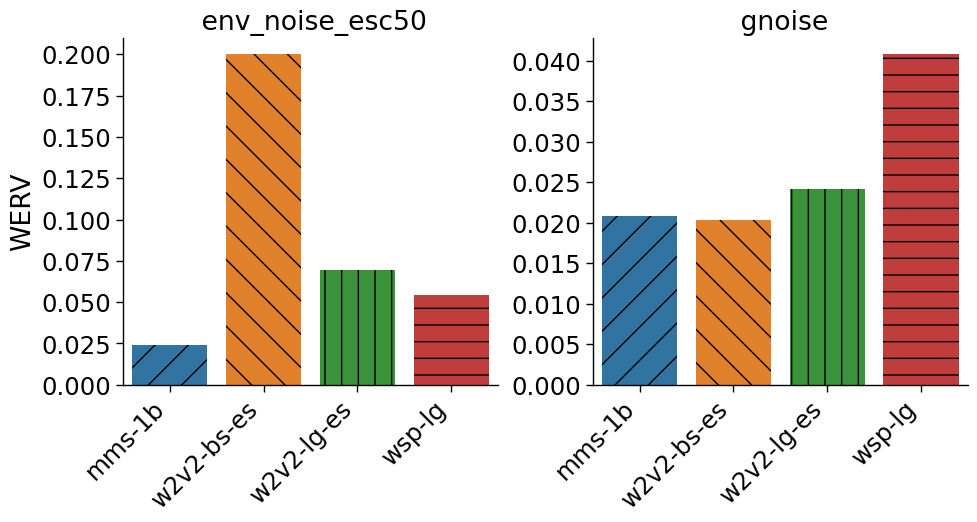

In [187]:
data = deepcopy(df[(df['augmentation'].isin(['gnoise', 'env_noise_esc50'])) & (df['severity'] == 1) & (df['pert_idx'] > 0)  & (df['language'] == 'es')])
data = data.pivot_table(index=['model', 'model (abrv)', 'augmentation', 'pert_idx'], values=['num_ref_words', 'num_word_errors'], aggfunc='sum').reset_index()
data['WER'] = 100 * data['num_word_errors'].values / data['num_ref_words'].values
data = data.pivot_table(index=['model', 'model (abrv)', 'augmentation'], values='WER', aggfunc='var').reset_index()
data = data.rename(columns={'WER': 'WERV', 'augmentation': 'perturbation'})
data = data[(~(data['model'].isin(['deepspeech', 'whisper-tiny', 'whisper-tiny.en', 'wav2vec2-base-960h'])))]
plt.close('all')
with sns.plotting_context('paper', font_scale=2):
    g = sns.catplot(data=data, x='model (abrv)', y='WERV', kind='bar', col='perturbation', sharey=False)
    g.set_xticklabels(rotation=45, ha='right')
    g.set_xlabels('')
    for ax in g.axes.flatten():
        ax.set_title(ax.get_title().split('=')[-1])
        for bars in ax.containers:
            for bar, hatch in zip(bars, hatches):
                bar.set_hatch(hatch)
plt.show()

#### Overal WERV of English Models

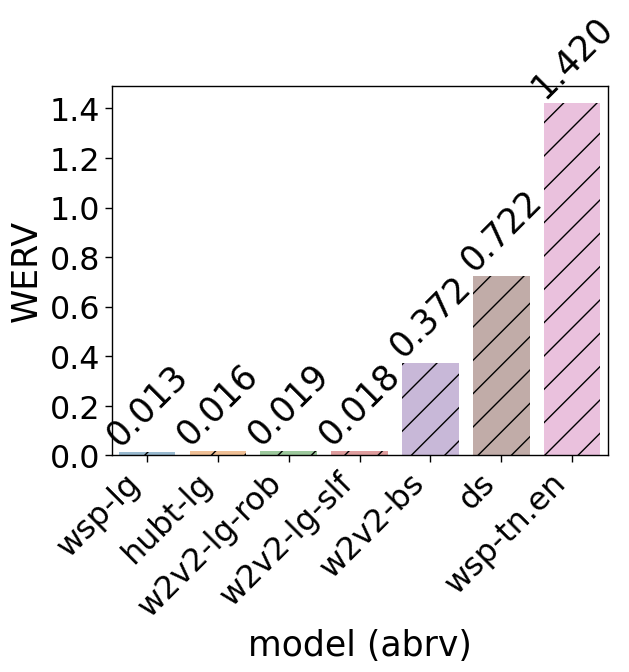

In [170]:
data = deepcopy(df[(df['augmentation'].isin(['gnoise', 'env_noise_esc50'])) & (df['severity'] == 1) & (df['pert_idx'] > 0)  & (df['language'] == 'en')])
data = data.pivot_table(index=['model', 'model (abrv)', 'augmentation', 'pert_idx'], values=['num_ref_words', 'num_word_errors'], aggfunc='sum').reset_index()
data['WER'] = 100 * data['num_word_errors'].values / data['num_ref_words'].values
data = data.pivot_table(index=['model', 'model (abrv)', 'augmentation'], values='WER', aggfunc='var').reset_index()
data = data.rename(columns={'WER': 'WERV', 'augmentation': 'perturbation'})
data = data[((data['model'].isin(en_models)))]# & (~(data['model'].isin(['whisper-tiny', 'whisper-tiny.en'])))]
data = data.sort_values(by='WERV', ascending=True)
# [(~(data['model'].isin(['whisper-tiny', 'whisper-tiny.en', 'deepspeech', 'wav2vec2-base-960h'])))]
with sns.plotting_context('paper', font_scale=2.6):
    ax = sns.barplot(data=data, x='model (abrv)', y='WERV', ci=False, alpha=0.5, hue_order=sorted(data['model (abrv)'].unique(), reverse=True))
    ax.bar_label(ax.containers[-1], fmt='%.3f', label_type='edge', rotation=45)
    plt.xticks(rotation=45, ha='right')
    # g.set_xlabels('')
    for bars, hatch in zip(ax.containers, hatches):
        # Set a different hatch for each group of bars
        for bar in bars:
            bar.set_hatch(hatch)
            
# data
plt.show()

In [36]:
plt.close('all')

#### Overal WERV of Spanish Models

In [148]:
data = deepcopy(df[(df['augmentation'].isin(['gnoise', 'env_noise_esc50'])) & (df['severity'] == 1) & (df['pert_idx'] > 0)  & (df['language'] == 'es')])
data = data.pivot_table(index=['model', 'model (abrv)', 'augmentation', 'pert_idx'], values=['num_ref_words', 'num_word_errors'], aggfunc='sum').reset_index()
data['WER'] = 100 * data['num_word_errors'].values / data['num_ref_words'].values
data = data.pivot_table(index=['model', 'model (abrv)', 'augmentation'], values='WER', aggfunc='var').reset_index()
data = data.rename(columns={'WER': 'WERV', 'augmentation': 'perturbation'})
# data = data[((data['model'].isin(en_models)))]# & (~(data['model'].isin(['whisper-tiny', 'whisper-tiny.en'])))]
data = data.sort_values(by='WERV', ascending=True)
plt.close('all')
with sns.plotting_context('paper', font_scale=2.4):
    ax = sns.barplot(data=data, x='model (abrv)', y='WERV', ci=False, alpha=0.5, hue_order=sorted(data['model (abrv)'].unique(), reverse=True))
    ax.bar_label(ax.containers[-1], fmt='%.4f', label_type='edge', rotation=45)
    plt.xticks(rotation=45, ha='right')
    # g.set_xlabels('')
    for bars, hatch in zip(ax.containers, hatches):
        # Set a different hatch for each group of bars
        for bar in bars:
            bar.set_hatch(hatch)

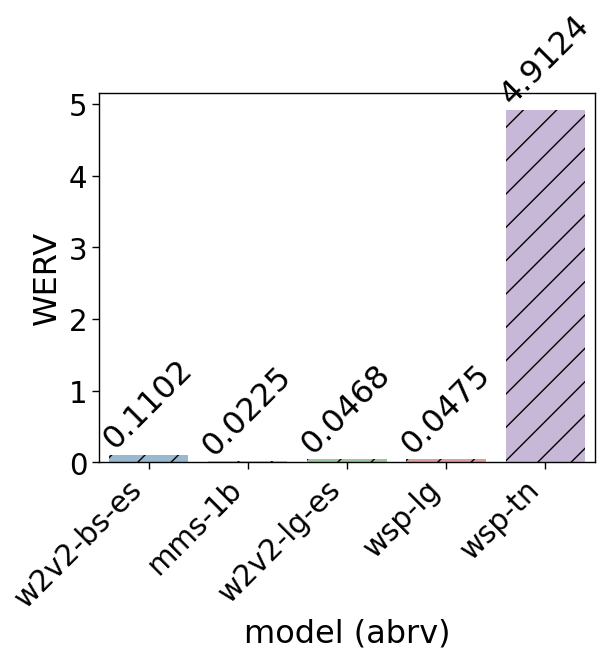

In [149]:
plt.show()